# Part 6.4 - Analysis Topic Model of Regions
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
#plt.style.use('seaborn-darkgrid')
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline

**In this part, we will use the topic modeling result from part 6.1 to analyze the topics of different regions.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/regions/topicKeys.csv'

df_topics = (pd.read_csv(path, 
                         header=None, 
                         index_col=None, 
                         names = ['topic_', 'weight_', 'keywords_'],
                         encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


topic_   weight_  \
0       0  0.002065   
1       1  0.006344   
2       2  0.001513   
3       3  0.007479   
4       4  0.005732   

                                                                                                                 keywords_  
0  theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...  
1  day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...  
2  election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...  
3  oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...  
4  christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...

**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/regions/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (891892, 6)


id      region  year  topic    weight  \
879256  33559126       Otago  1900    173  0.115880   
719007  27777637    Auckland  1870    108  0.103535   
495022  18215735  Wellington  1915     55  0.412893   
673177  24012880       Otago  1893     28  0.076497   
520895  18517726  Wellington  1921    176  0.253441   

                                                               keywords  
879256  love life heart day thy god world man eyes thou light long n...  
719007  thames auckland whangarei paeroa tauranga pollen street aroh...  
495022  wool market london sales new_zealand prices bales cent wheat...  
673177  tin ill oil day lit zealand ton mil tie aro hat fur aid ail ...  
520895  people man men good time money country work day make years g...

**Average topic weight dataframe:**

In [6]:
path = r'../models/regions/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


year  topic    weight  \
6097   1869     97  0.003445   
2970   1853    170  0.003239   
2785   1852    185  0.001941   
11434  1896     34  0.002510   
17805  1931      5  0.003095   

                                                              keywords  
6097   hospital medical health disease cases patients treatment cas...  
2970   advertisements office prizes subscribers column prize paper ...  
2785   dam season horse mares stand terms sire mare imported partic...  
11434  wellington arrived morning nelson sailed tons auckland to-mo...  
17805  association press received telegraph copyright london united...

## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [8]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

id      region  year  topic    weight  \
482449  18086539  Wellington  1926    133  0.967722   
332272  14604562  Canterbury  1915    191  0.877316   
358567  16017671  Canterbury  1918     14  0.862669   

                                                               keywords  
482449  court case justice appeal evidence judge supreme decision ma...  
332272  sale apply land house acres particulars property terms good ...  
358567  freight apply company passage new_zealand passengers steam l...

In [9]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

18086539

In [10]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 18086539
1069296:18086539	Page 2 Advertisements Column 5	"J)E LUXE COMMENCING FRIDAY NEXT! THE MIGHTY WILLIAM FOX EPIC OF THE SCREEN. HAVO4 HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC! HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC\" HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC rr ' HAVOC HAVOC HAVO

## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the first 20 topics in topics list.**

In [11]:
df_plt = df_topics.copy(deep=True)

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords'].map(addWeight)

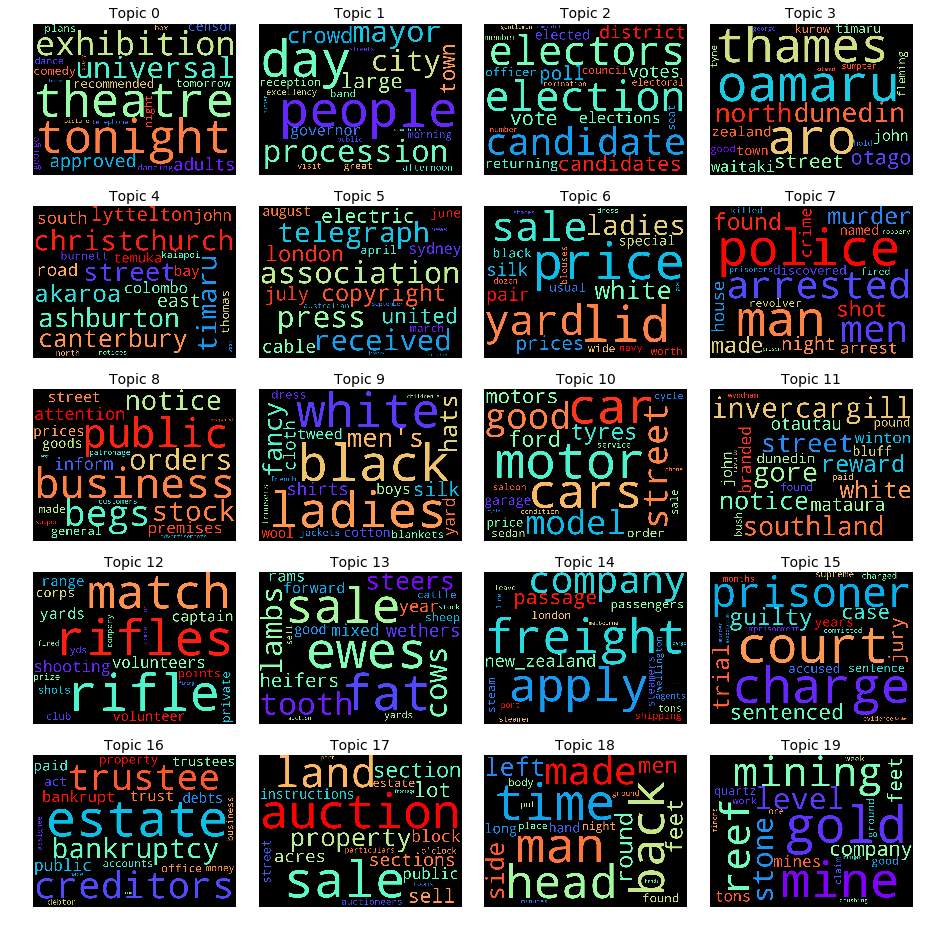

In [12]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

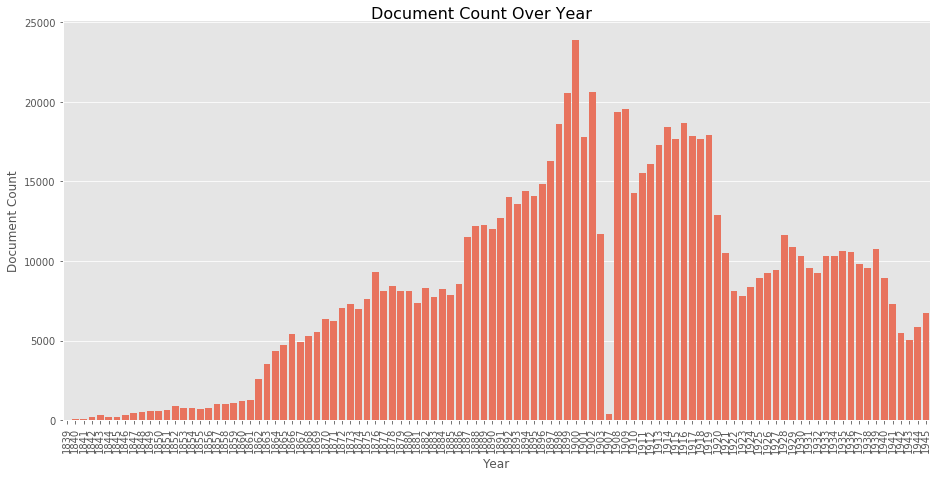

In [13]:
g = sns.catplot(x="year", color='tomato',
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Year", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Year', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general.**

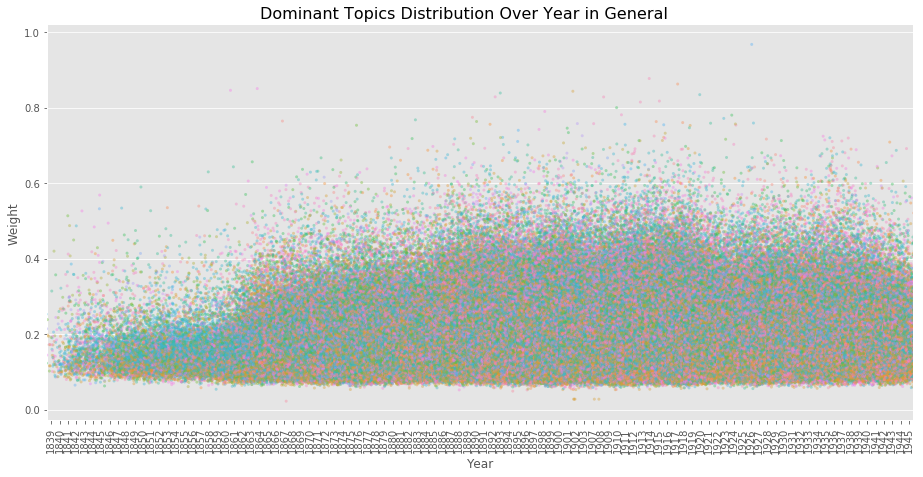

In [14]:
g = sns.catplot(x="year", y='weight', hue='topic',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.4, edgecolors='w',
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Year in General", fontsize=16)
g.set(xlabel='Year', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

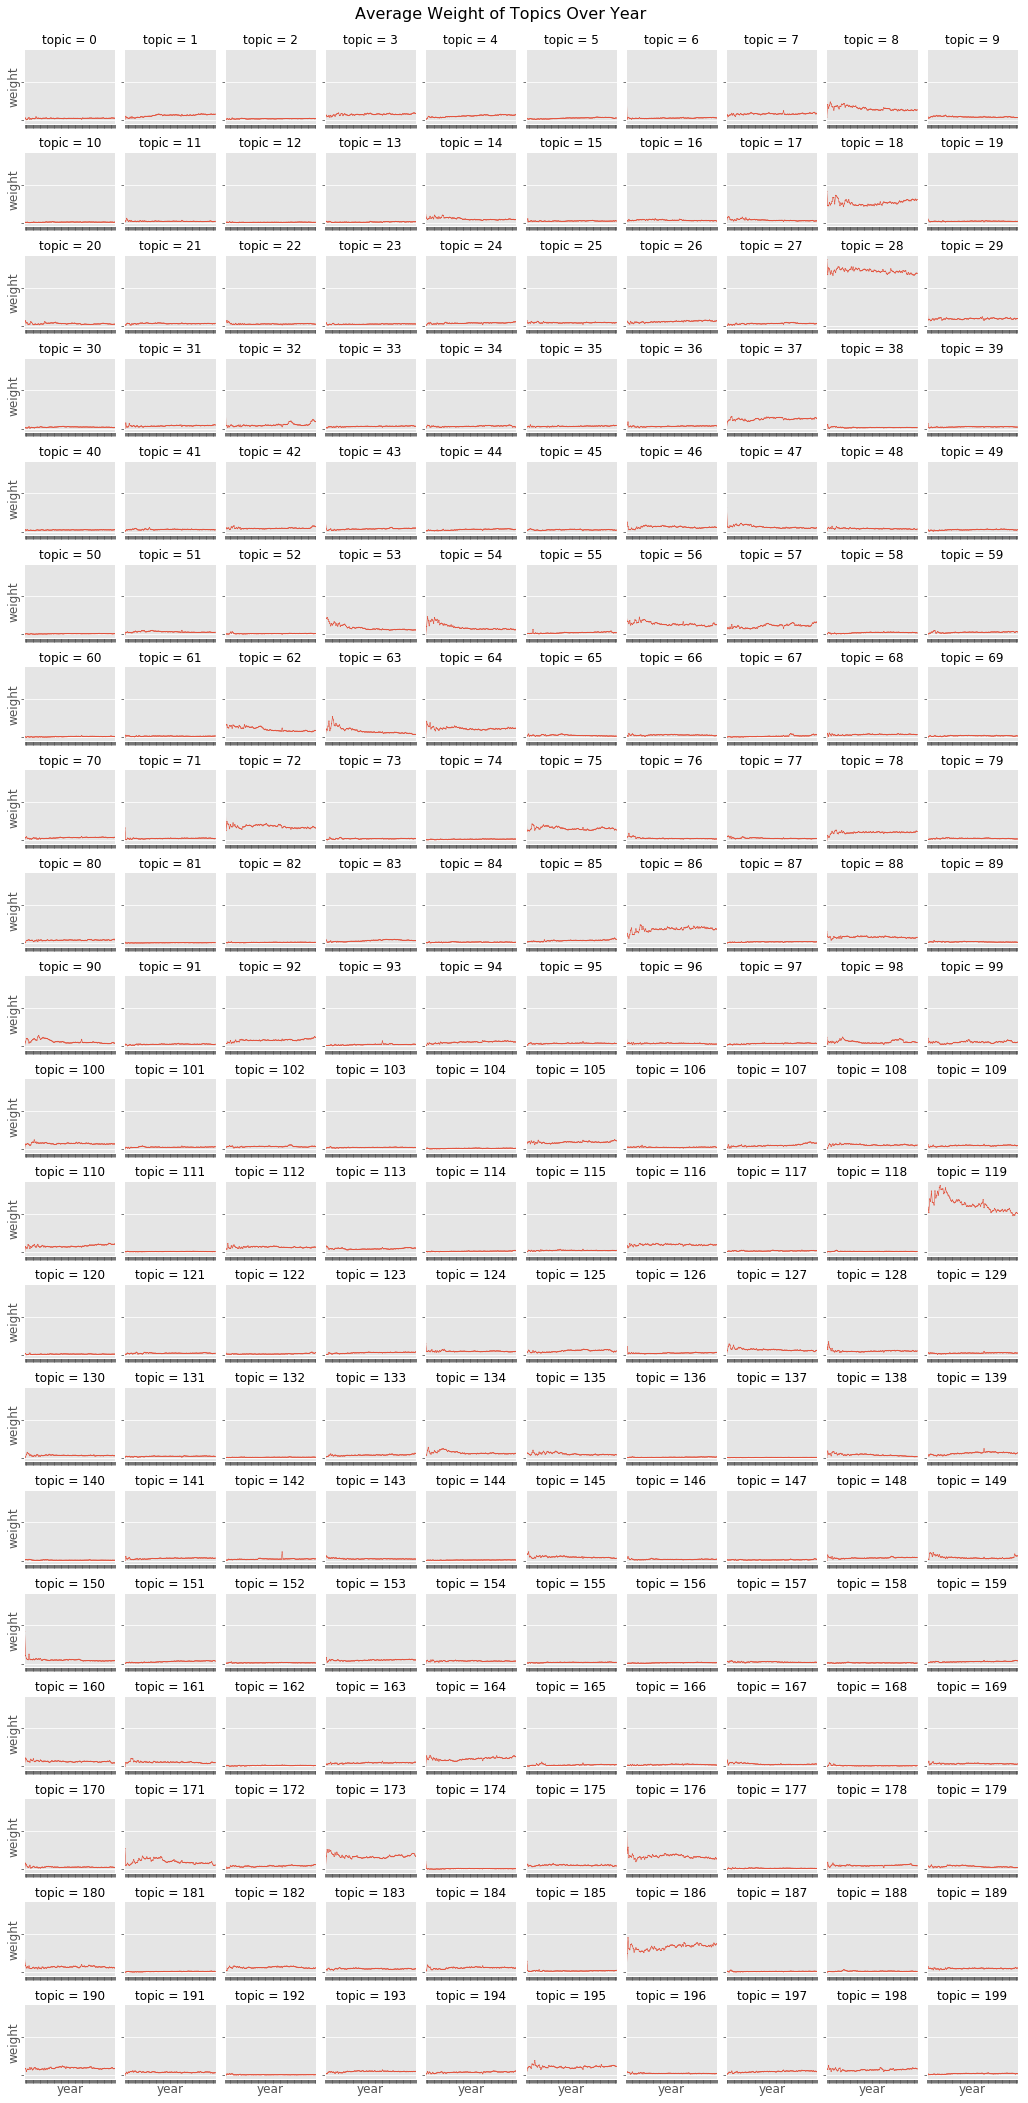

In [15]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Average Weight of Topics Over Year", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [16]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (26327, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic             
0      0.002065   
1      0.006344   
2      0.001513   
3      0.007479   
4      0.005732   
5      0.002559   
6      0.002438   
7      0.007893   
8      0.013902   
9      0.003730   

                                                                                                                      keywords  
topic                                                                                                                           
0      theatre tonight exhibition universal approved adults censor recommended comedy tomorrow night plans dance george dan...  
1      day people procession mayor city crowd town large governor reception band morning great afternoon excellency visit p...  
2      election electors candidate candidates vote poll district votes elections returning elected officer council seat ele...  
3      oamaru aro thames dunedin north otago street waitaki john zealand town timaru kurow fleming good tyne sumpter hold g...  
4      christchurch timaru ashburton street canterbury akaroa lyttelton east road south john colombo bay temuka thomas burn...  
5      association press received telegraph copyright london united electric july cable sydney august june april march aust...  
6       price lid yard sale ladies white prices pair silk special black usual wide worth navy blouses dozen dress shades good   
7      police man arrested men murder found made shot night house crime arrest named discovered revolver fired killed priso...  
8      business public begs orders stock notice attention inform premises street prices goods general made patronage custom...  
9      black ladies white men's fancy hats silk shirts cloth yard tweed boys wool cotton dress blankets jackets trousers fr...

**Dominant topics distribution over year:**

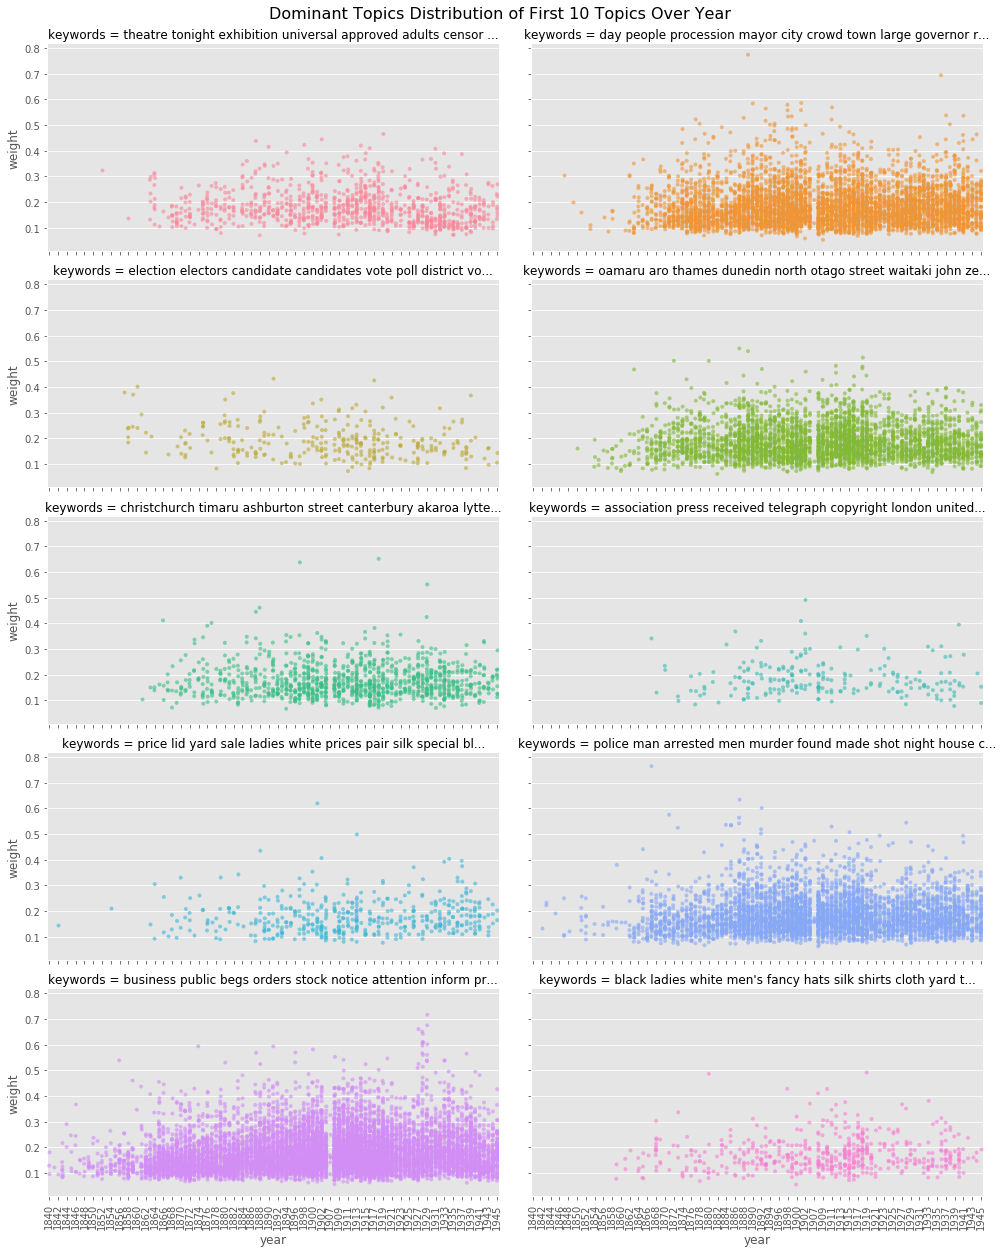

In [17]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

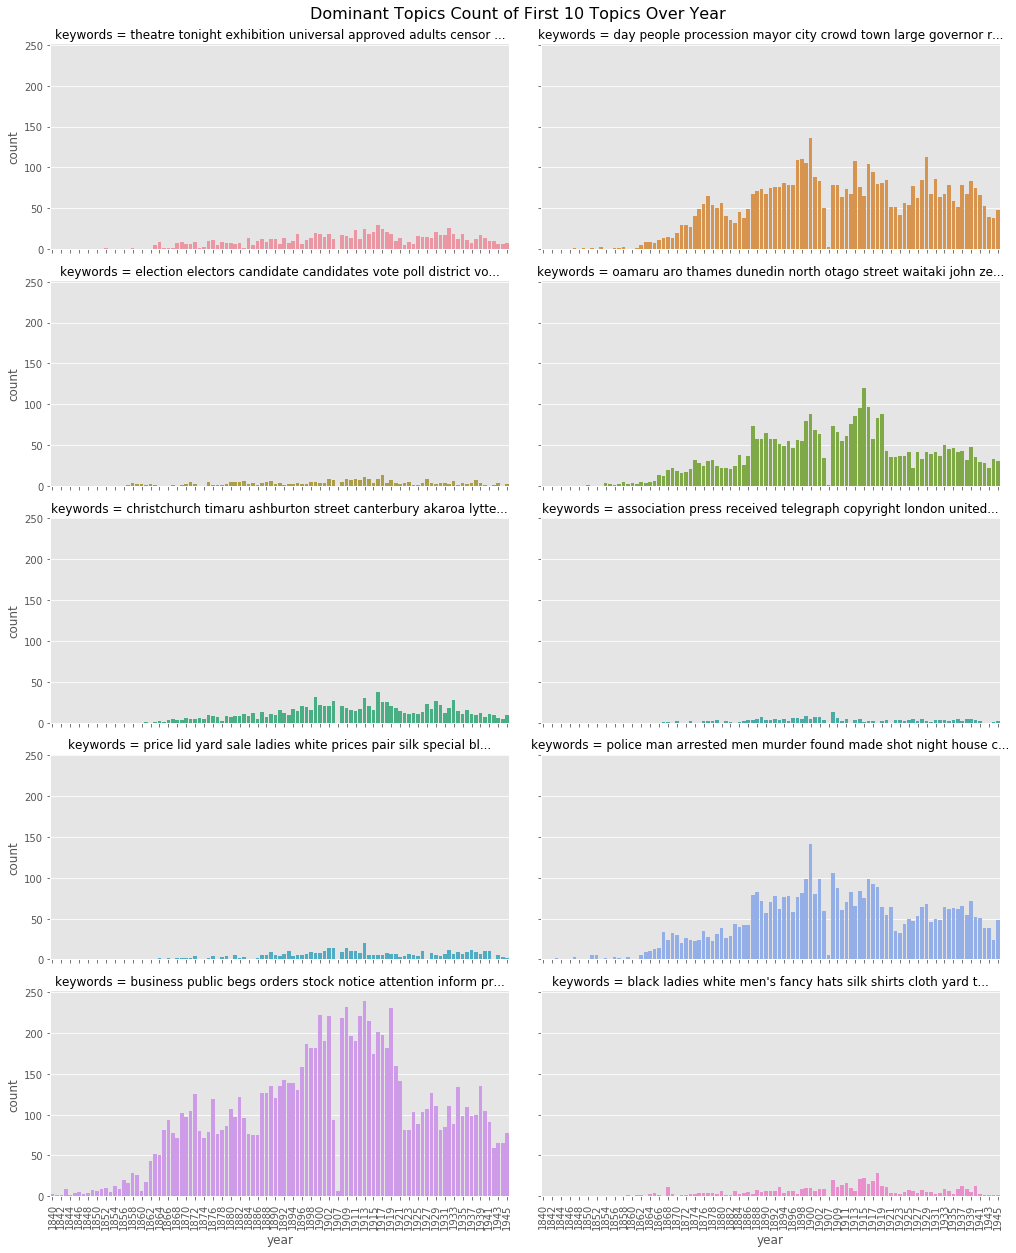

In [18]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

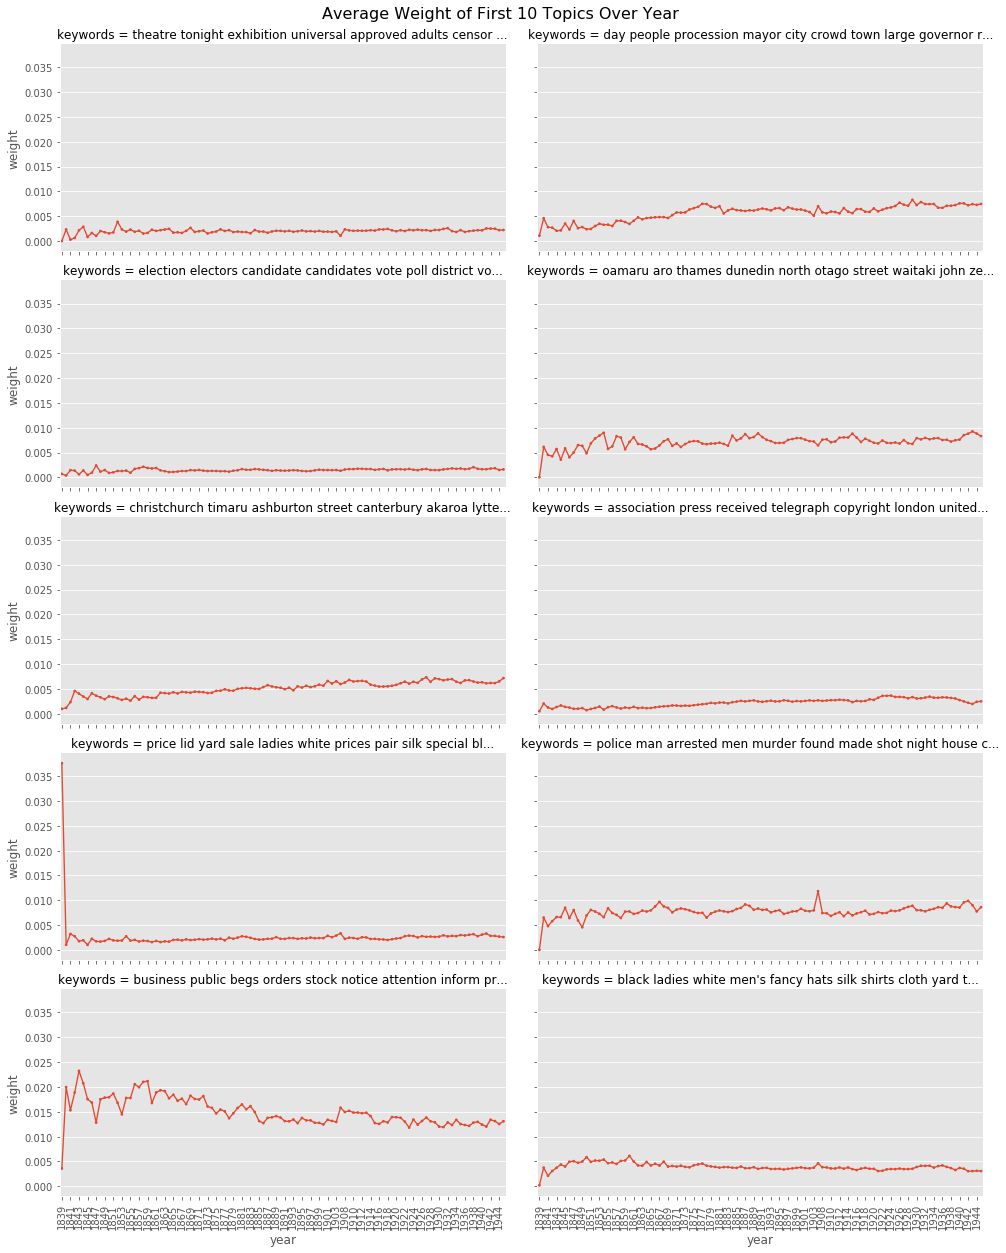

In [19]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

## 5 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [20]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])
signif_topic_list = topic_list

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [119, 28, 186, 18, 86, 72, 176, 173, 64, 57]
Shape of df_plt_dom: (548451, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic             
119    0.059164   
28     0.071128   
186    0.034272   
18     0.025825   
86     0.019291   
72     0.017893   
176    0.016989   
173    0.016410   
64     0.011139   
57     0.012045   

                                                                                                                      keywords  
topic                                                                                                                           
119    public people men question great time good law country man present fact matter state opinion case system means gover...  
28                                      tin ill oil day lit zealand ton mil tie aro hat fur aid ail man end tins wai hut time   
186    man life great years world men time people work english human history good made fact long character nature modern mind   
18                 time man back head made left side round feet men long hand found night body place put ground minutes hands   
86     time good present made great work fact large year number doubt place make years long past position matter success co...  
72     meeting evening yesterday held morning messrs night saturday wellington made number court district company local wee...  
176             people man men good time money country work day make years great business things pay thing life find put poor   
173                    love life heart day thy god world man eyes thou light long night earth great sweet thee death men home   
64               man face eyes lady time room young thought hand looked back girl asked door love made house knew moment told   
57     london lord house irish ireland sir commons government home received bill lords rule parliament british gladstone du...

**Dominant topics distribution over year:**

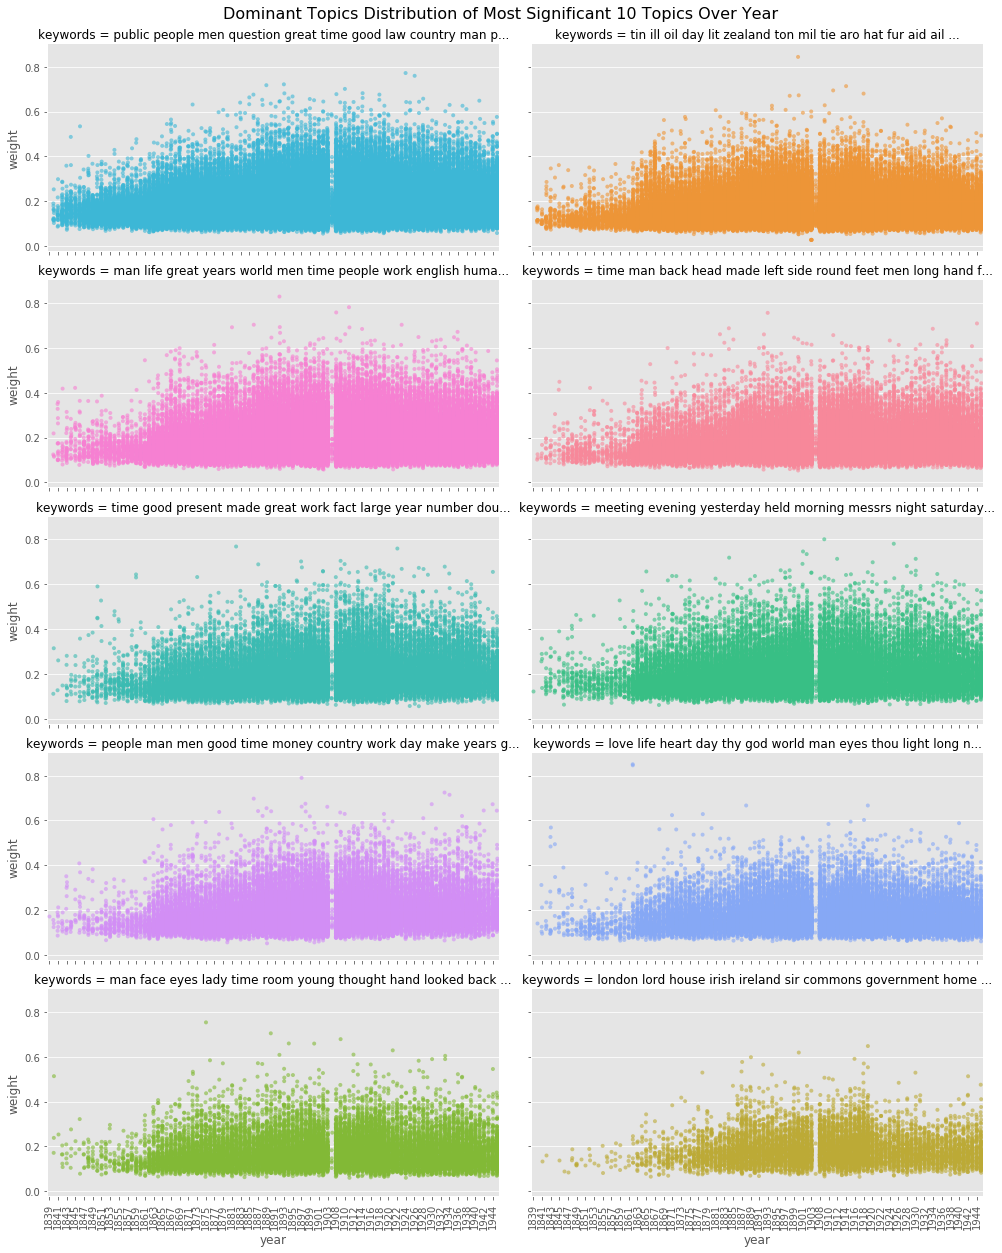

In [21]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

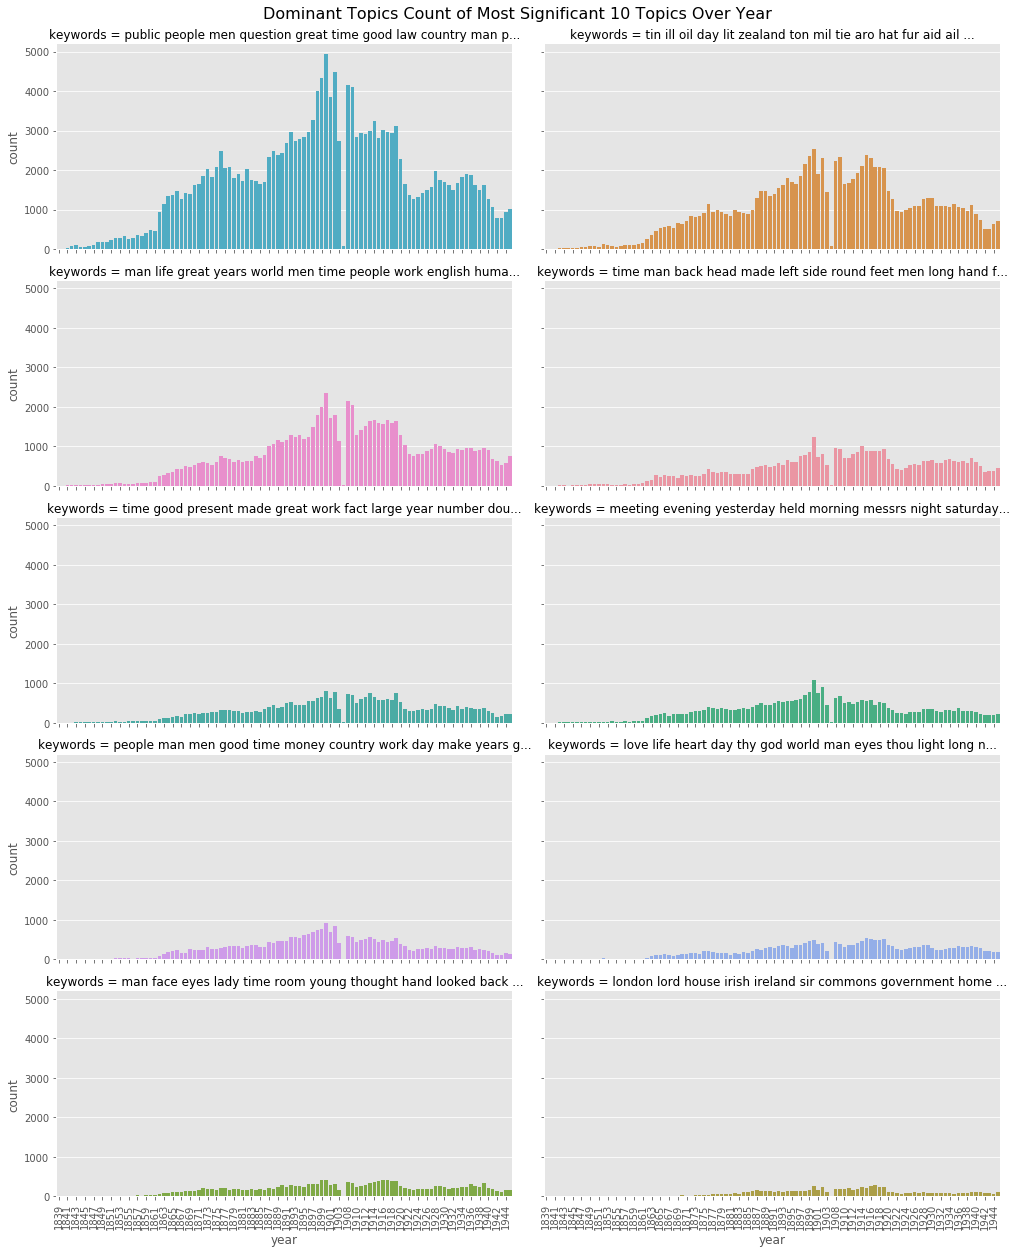

In [22]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

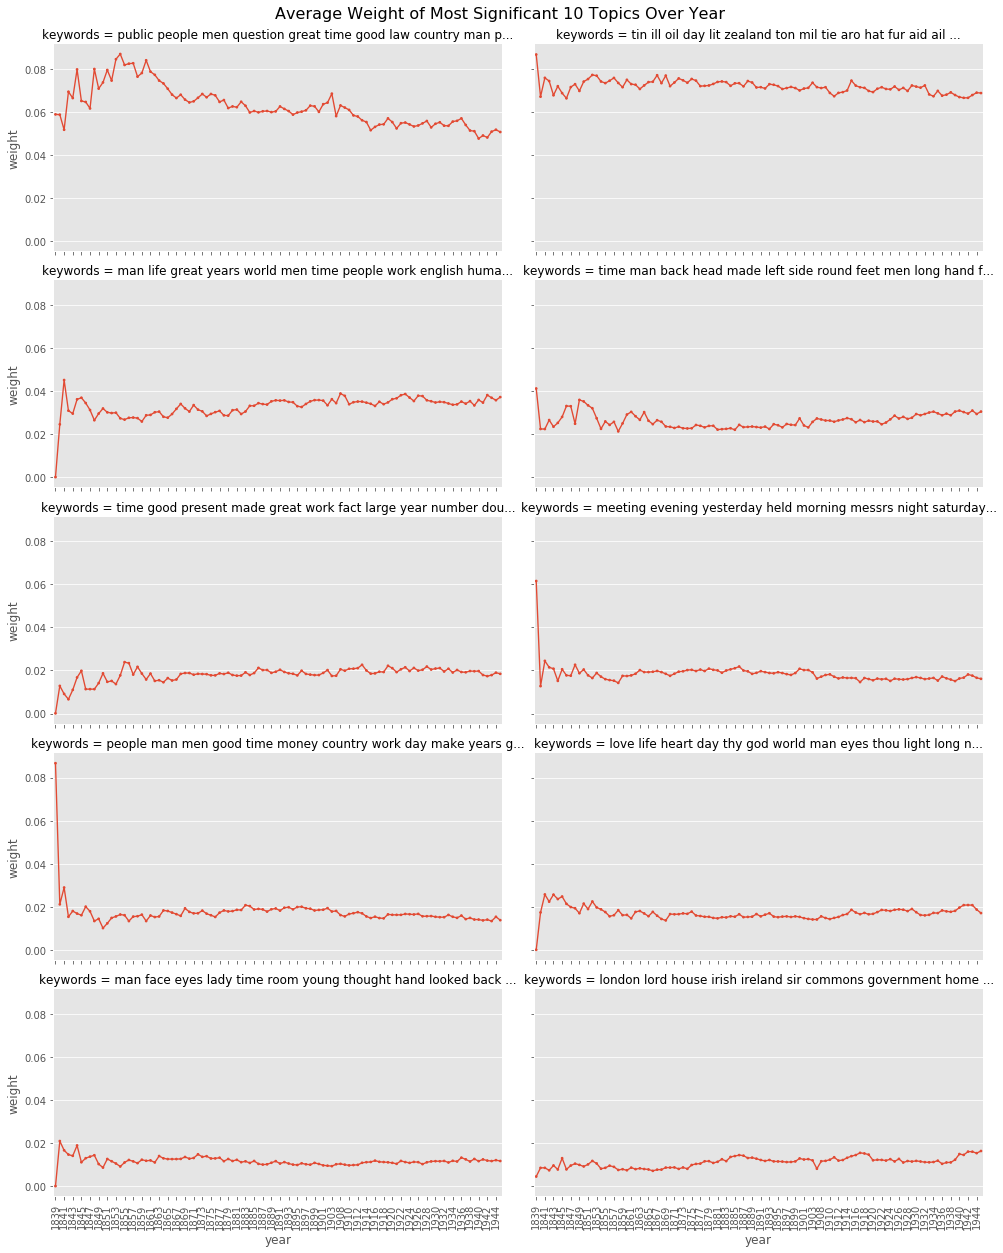

In [23]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

## 6 The Most Different Topics

### 6.1 Differet Topics from Other Regions

**By compare the topic weight in topic list, we can find out which topics are the most different in the regions. Here we are interested in both trend (the more or less popular topics) in the regions. The regions are Auckland, Wellington, Canterbury and Dunedin.**

In [24]:
path = r'../models/regions/topicKeysOthers.csv'

df_topics_others = (pd.read_csv(path, 
                                header=None, 
                                index_col=None, 
                                names = ['topic_', 'weight_', 'keywords_'],
                                encoding='utf8')
                    .sort_values(by='topic_')
                    .reset_index(drop=True))

df_diff = df_topics_others.join(df_topics)

# to find more populare topics
#df_diff['diff'] = (df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])
# to find more populare or contrary trend topics
df_diff['diff'] = abs(df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])

df_diff = df_diff.sort_values(by='diff', ascending=False)

topic_list = list(df_diff['topic'][:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [5, 192, 52, 136, 187, 50, 147, 140, 111, 44]
Shape of df_plt_dom: (2369, 6)
Shape of df_plt_avg: (1040, 4)


weight  \
topic             
5      0.002559   
192    0.000521   
52     0.001130   
136    0.000725   
187    0.001146   
50     0.000959   
147    0.001046   
140    0.000583   
111    0.000525   
44     0.002914   

                                                                                                                      keywords  
topic                                                                                                                           
5      association press received telegraph copyright london united electric july cable sydney august june april march aust...  
192    moon quarter weather wind breeze water calm light high sun bar sets cape sky heads clouds barometer morning full to-...  
52     mails mail close office notices auckland letters wellington united_kingdom chief late europe post london due fee con...  
136    time won sec started min lengths length handicap mile half ssec furlongs meeting ran day easily weather results soys...  
187    men military private army camp officers service war new_zealand soldiers defence colonel officer captain training wo...  
50     wellington auckland dunedin christchurch canterbury new_zealand otago association north wanganui napier nelson press...  
147    acres good acre price house land cash miles terms farm balance grass sheep cows school paddocks roomed property wate...  
140    soys handicap horse race nomination stakes acceptance receive hack soy mile miles distance horses weights stake star...  
111    sellers buyers stock bank new_zealand sales national auckland exchange waihi cent pref insurance share ord wellingto...  
44     enemy german germans front french london british fighting troops attack received captured russian artillery line sta...

**Dominant topics distribution over year:**

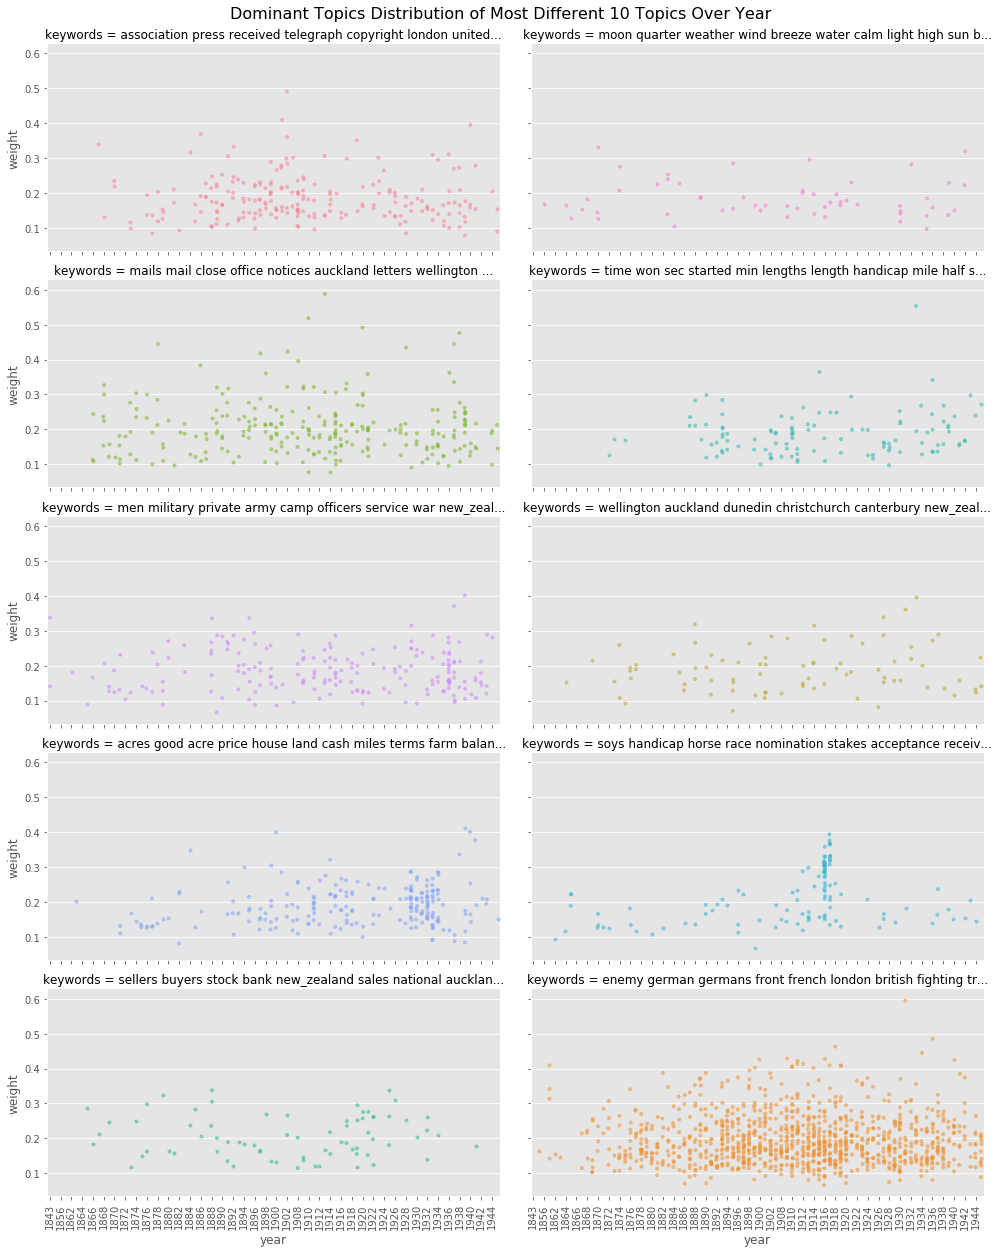

In [25]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

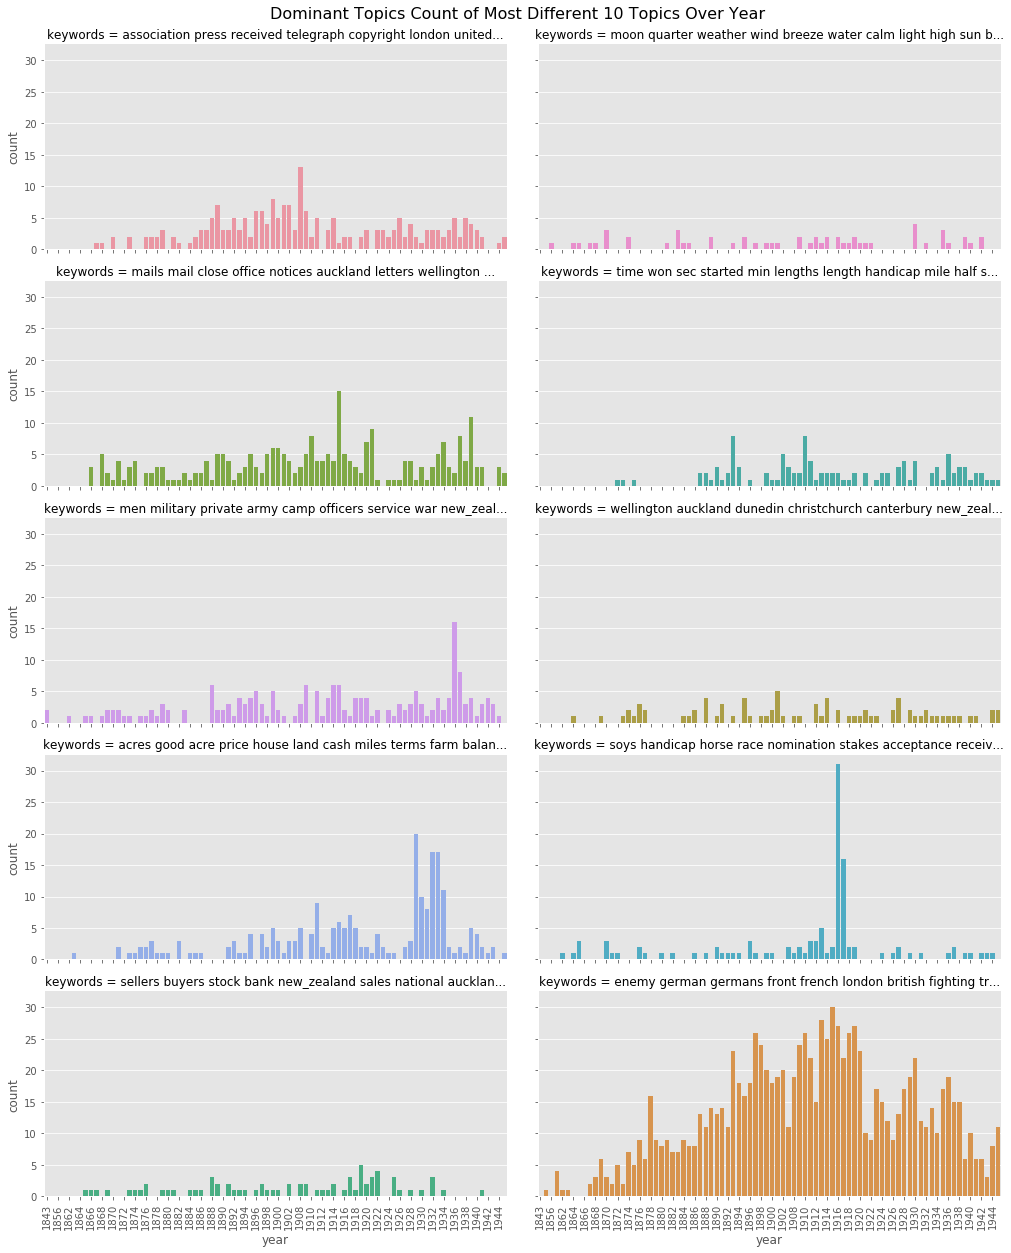

In [26]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

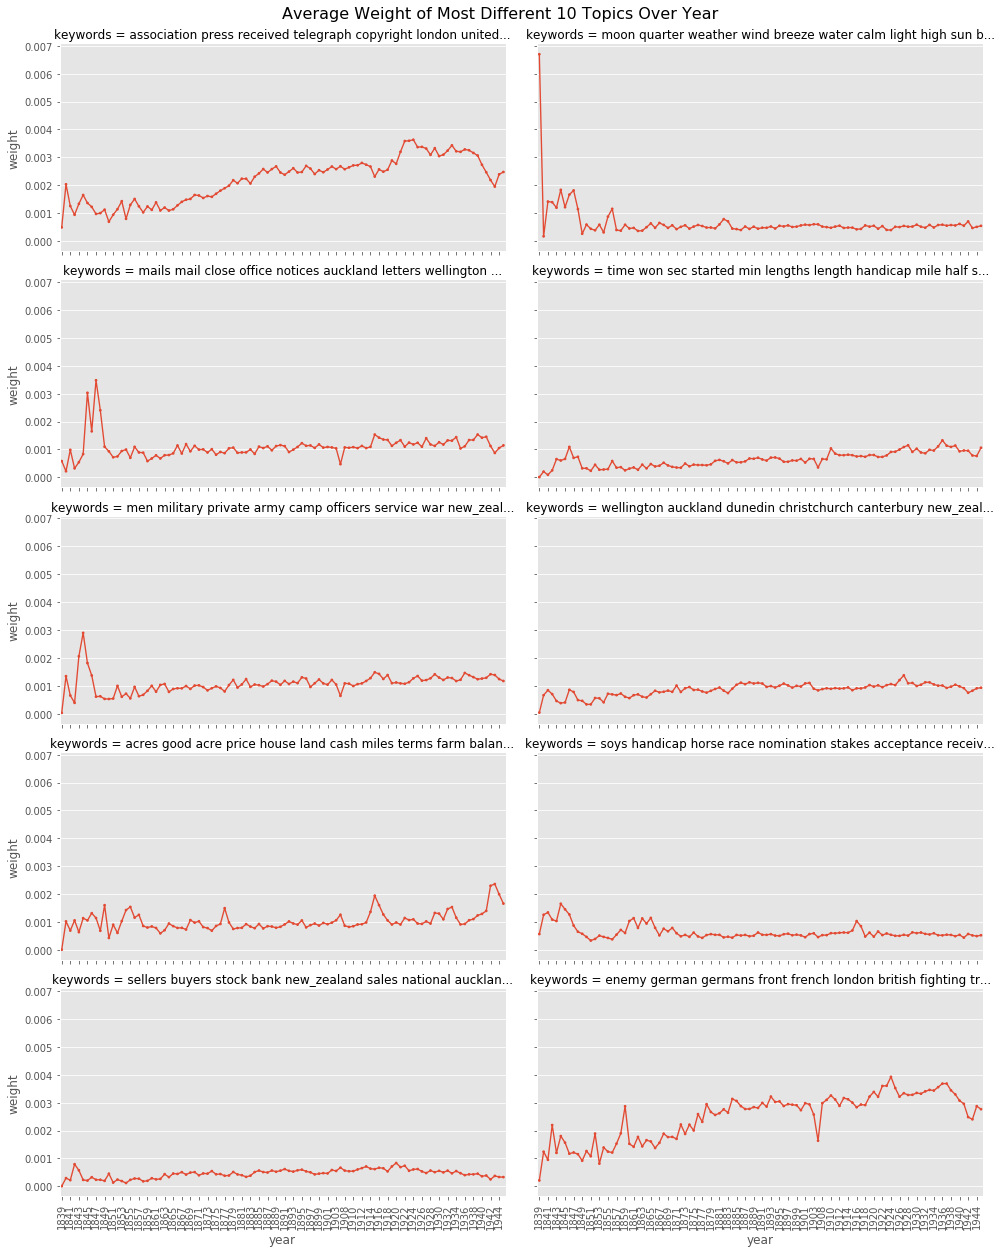

In [27]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

### 6.2 Different Topics Among The Regions

**Now we compare the different among the regions: Auckland, Wellington, Canterbury and Otago. We use 4 topics in the most significant topics list to check the different among the 4 regions.** 

In [28]:
regions = ['Auckland', 'Wellington', 'Canterbury', 'Otago']
topic_list = signif_topic_list[:4]
print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = list(df_col_order.keywords.str.slice(0,60)+'...')
df_col_order.head()

List of topics to plot: [119, 28, 186, 18]
Shape of df_plt_dom: (404702, 6)
Shape of df_plt_avg: (416, 4)


weight  \
topic             
119    0.059164   
28     0.071128   
186    0.034272   
18     0.025825   

                                                                                                                      keywords  
topic                                                                                                                           
119    public people men question great time good law country man present fact matter state opinion case system means gover...  
28                                      tin ill oil day lit zealand ton mil tie aro hat fur aid ail man end tins wai hut time   
186    man life great years world men time people work english human history good made fact long character nature modern mind   
18                 time man back head made left side round feet men long hand found night body place put ground minutes hands

**Dominant topics distribution over year:**

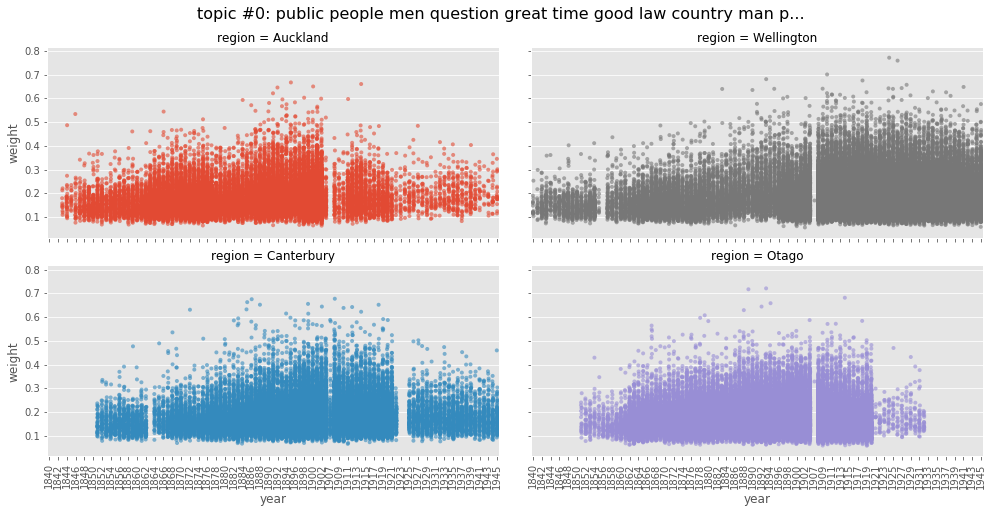

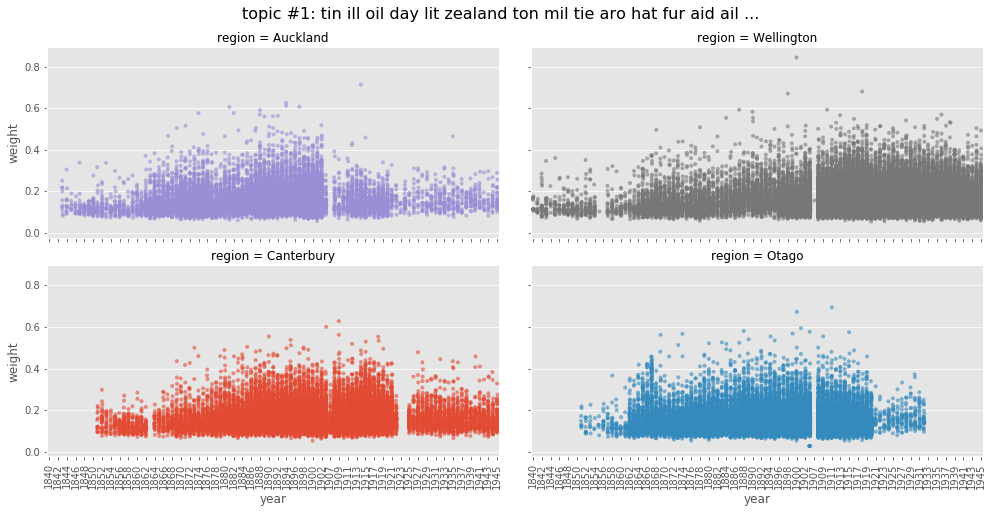

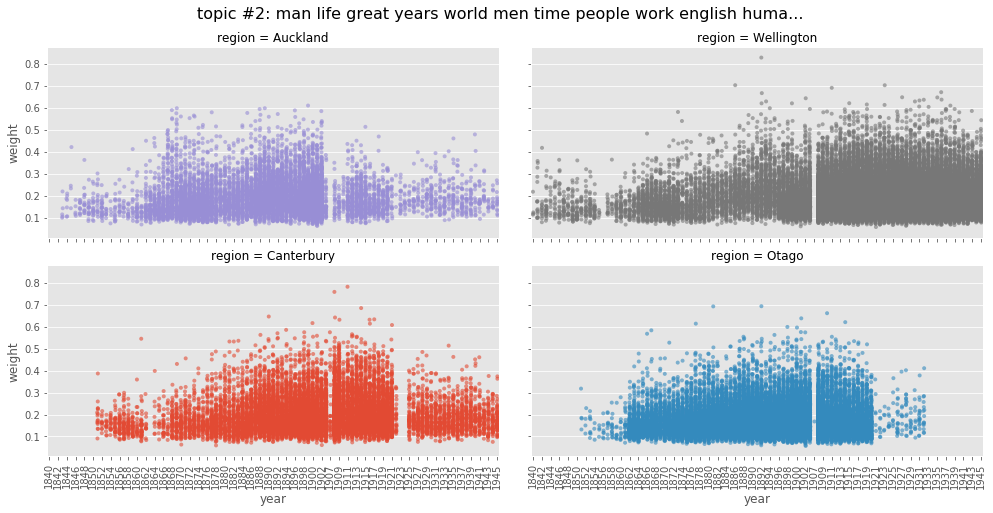

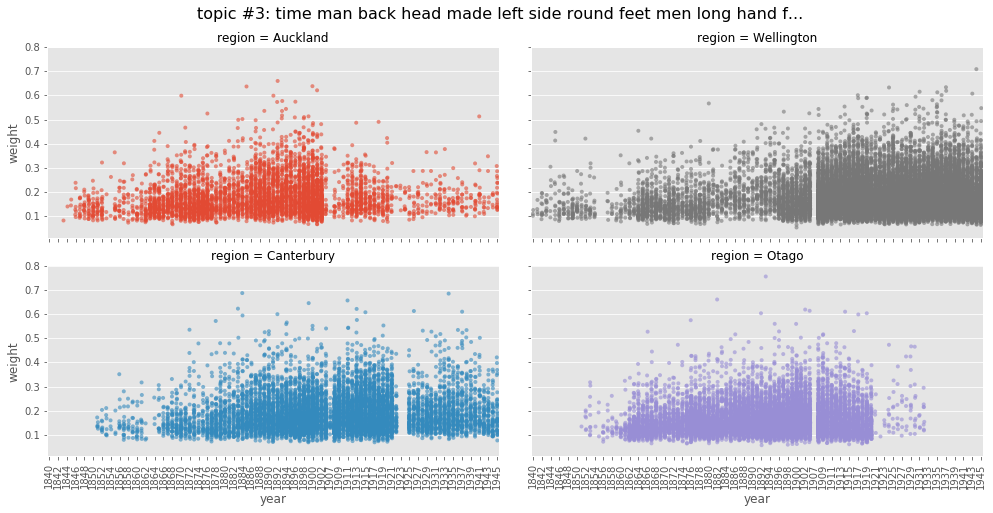

In [29]:
for i in range(4):
    g = sns.catplot(x='year', y='weight', hue='region', col='region',
                    col_order=regions, col_wrap=2,
                    s=4, alpha=0.6, edgecolors='w', legend=False,
                    kind='strip', height=3.5, aspect=2, jitter=1, dodge=False,
                    data=df_plt_dom[df_plt_dom['topic'] == topic_list[i]])
    g.fig.subplots_adjust(top=0.90)
    g.fig.suptitle('topic #{}: {}'.format(i, col_order[i]), fontsize=16)
    g.set_xticklabels(rotation=90, step=2)

**Dominant topics count over year:**

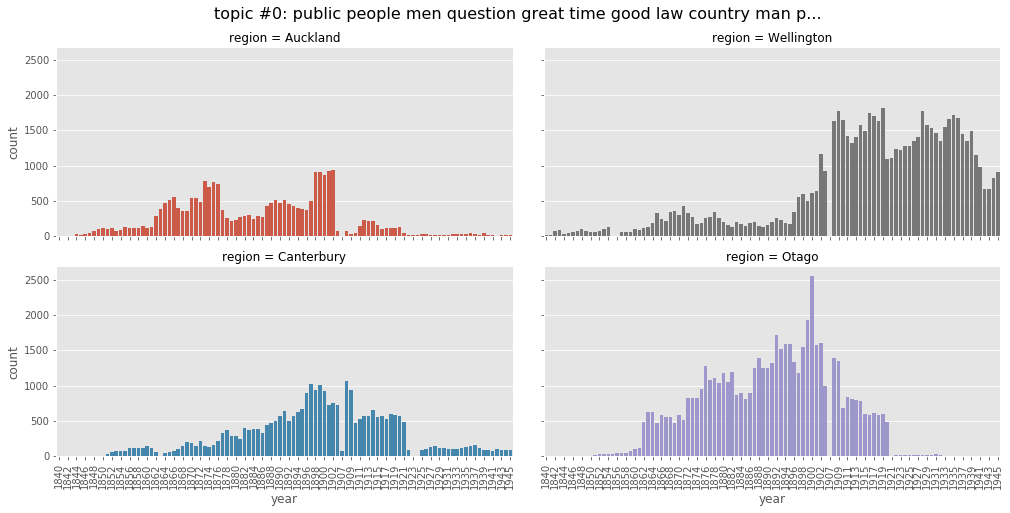

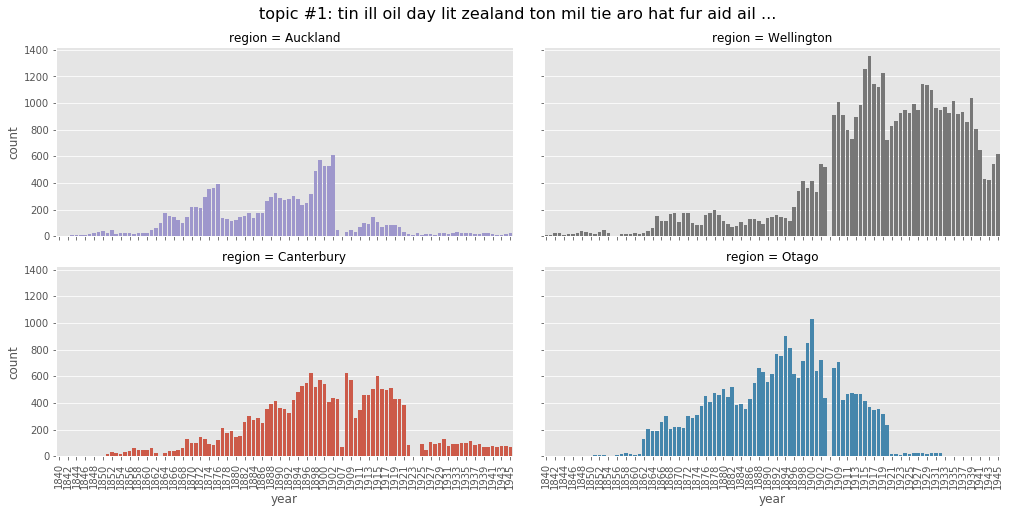

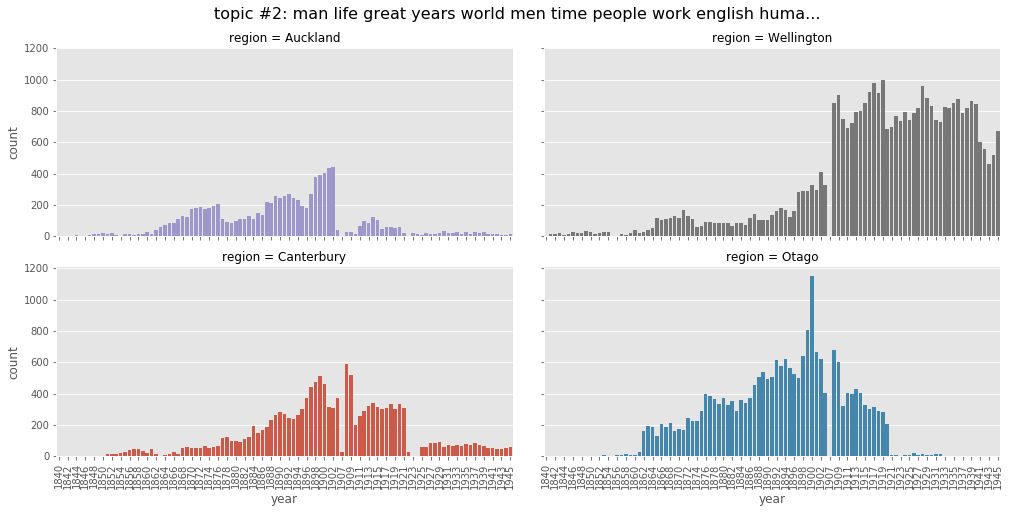

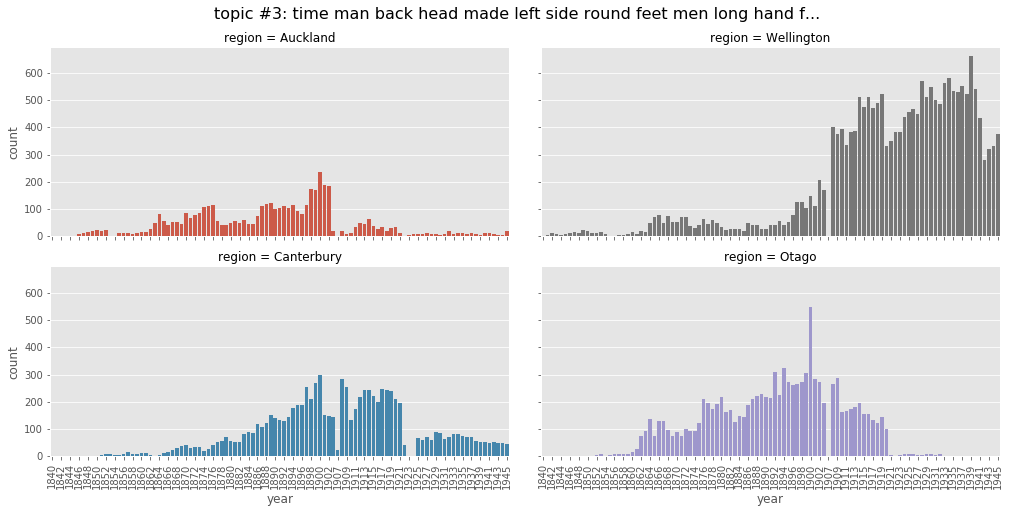

In [30]:
for i in range(4):
    g = sns.catplot(x='year', hue='region', col='region',
                    col_order=regions, col_wrap=2, legend=False,
                    kind='count', height=3.5, aspect=2, dodge=False,
                    data=df_plt_dom[df_plt_dom['topic'] == topic_list[i]])
    g.fig.subplots_adjust(top=0.90)
    g.fig.suptitle('topic #{}: {}'.format(i, col_order[i]), fontsize=16)
    g.set_xticklabels(rotation=90, step=2)

---

In [31]:
gc.collect()

3333085